# Recruit Restaurant Visitor Forecasting

#### A Kaggle Competition Kernel <br>

Created by

[Shaoqian Tang](#https://github.com/shaoqiantang)<br>
[Yiqing Yang](#https://github.com/yiqingyang75)<br>
[Siyu Wang](#https://github.com/swang623)<br>
[Yiyi Han](#https://github.com/UnoYiyi)<br>
[Anil Jacob](#https://github.com/arjacob)<br>

<img src="https://cdn.shopify.com/s/files/1/1540/0729/articles/CA1_1045F_2000x2000.jpg?v=1476492525" alt="Alt text that describes the graphic" title="Title text" />



## Project Overview

[Click Here To View Competition Page](#https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)

This project aims to help restaurants predict __the number of customers to expect__ on a daily basis to optimize inventory and staff resources. 


## Table of Contents

1. [Environment Setup](#1)<br>
    1.1 [Loading Needed Packages](#1.1)<br>
    1.2 [Loading Available Datasets](#1.2)<br>
    1.3 [Data Disctionary](#1.3)<br>
2. [Data Exploration & Feature Engineering](#2)<br>
    2.1 [Train Store Information](#2.1)<br>
    2.2 [Visitor Information](#2.2)<br>
    2.3 [Reservations](#2.3)<br>
    2.4 [Area](#2.4)<br>
    2.5 [Genre](#2.4)<br>
3. [Data Preparation for Modeling](#3)<br>
4. [Modeling](#4)<br>
    4.1 [Loading Packages & Setup](#4.1)<br>
    4.2 [Define RMSLE](#4.2)<br>
    4.3 [Set up Cross Validation](#4.3)<br>
    4.4 [Linear Regression](#4.4)<br>
    4.5 [Random Forest](#4.5)<br>
    4.6 [XGBoost](#4.6)<br>
    4.7 [Model Comparison](#4.7)<br>
5. [Summary](#5)<br>
 

<a id = '1'></a>

## Step 1: Setting up the Environment

<a id = '1.1'></a>

### 1.1 Loading Needed Packages

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, warnings
from scipy import stats
from mpl_toolkits.basemap import Basemap
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import LabelEncoder

<a id = '1.2'></a>
### 1.2 Loading Available Datasets

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
file_list = check_output(["ls", "../input"]).decode("utf8")
file_list = file_list.strip().split('\n')

air_reserve.csv
air_store_info.csv
air_visit_data.csv
date_info.csv
hpg_reserve.csv
hpg_store_info.csv
sample_submission.csv
store_id_relation.csv
test.libsvm
test_x.csv
test_y.csv
train.libsvm
Xtest_book.csv



In [ ]:
for index, file in enumerate(file_list):
    var_name = file.rstrip('.csv')
    locals()[var_name] = pd.read_csv('../input/' + file)
    print(file)

<a id = '1.3'></a>
### 1.3 Data Dictionaries

__Data Sources__
- Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
- AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

__Table 1: air_reserve__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
visit_datetime| time of the reservation
reserve_datetime | time the reservation was made
reserve_visitors | number of visitors for that reservation


__Table 2: hpg_reserve__

Column Name | Column Description
-------------|:------------------
hpg_store_id | restaurant id in the hpg system
visit_datetime| time of the reservation
reserve_datetime | time the reservation was made
reserve_visitors | number of visitors for that reservation

__Table 3: air_store_info__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
air_genre_name | genre in the air system
air_area_name | area of the restaurant in the air system
latitude | latitude
longitude | longitude

__Table 4: hpg_store_info__

Column Name | Column Description
-------------|:------------------
hpg_store_id | restaurant id in the hpg system
hpg_genre_name | genre in the hpg system
hpg_area_name | area of the restaurant in the hpg system
latitude | latitude
longitude | longitude

__Table 5: air_visit_data__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
visit_date | date
visitors | the number of visitors to the restaurant on the date

__Table 6: date_info__

Column Name | Column Description
-------------|:------------------
calendar_date | date
day_of_week | day of the week
holiday_flg | if the day is a holiday in Japan


<a id = '2'></a>
## Step 2: Data Exploration and Feature Engineering

In [3]:
# convert to datetime
    for col in locals()[var_name].columns:
        if col.endswith('datetime') or col.endswith('date'):
            locals()[var_name][col] = pd.to_datetime(locals()[var_name][col])
    
    print('Shape:', locals()[var_name].shape)
    print('\n')
    print(locals()[var_name].info())
    print('\n')
    print(locals()[var_name].head())
    print('***********************************************************************************')

air_reserve.csv
Shape: (92378, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB
None


           air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
3  air_877f79706adbfb06 2016-01-01 20:00:00 2016-01-01 16:00:00   
4  air_db80363d35f10926 2016-01-01 20:00:00 2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5  
**************************************************************

<a id = '2.1'></a>

### 2.1 Training Set Store Information

In [4]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


#### FIGURE 1: Store Distribution map

The two maps below show the distribution of stores recorded in air and hpg. While the overall distribution looks similar for both sources, hpg seems to include more restaurants than air.

Text(0.5,1,'air_store distribution')

Text(0.5,1,'hpg_store distribution')

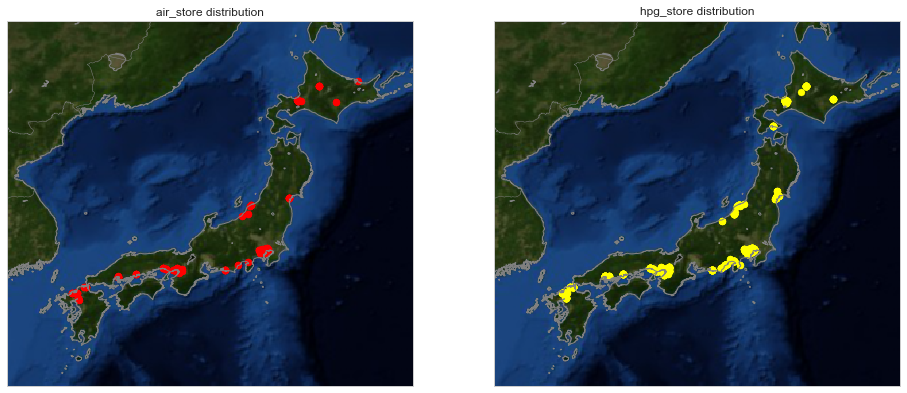

In [5]:
fig,ax = plt.subplots(1,2,figsize = (16,16))

color = ['red','yellow']
title = ['air_store distribution', 'hpg_store distribution']
for i,data in enumerate([air_store_info,hpg_store_info]):
    m = Basemap(resolution = 'h',lon_0 = 0, lat_0 = 0,llcrnrlon=127, urcrnrlon=147,
                      llcrnrlat=29, urcrnrlat=47, ax = ax[i])
    m.bluemarble()
    m.drawcoastlines(color = 'gray')
    m.drawcountries(color = 'gray')
    m.drawstates(color = 'gray')
    m.scatter(data['longitude'], data['latitude'], latlon = True, color = color[i], marker='o')
    ax[i].set_title(title[i])

In [ ]:
# Let's see the exact number of stores in each dataset

hpg_store_num = hpg_store_info['hpg_store_id'].nunique()
air_store_num = air_store_info['air_store_id'],nunique()

print(f'There are {hpg_store_num} hpg stores')
print(f'There are {air_store_num} air stores')bm


# !!!!!!NEED A CONCLUSION HERE ABOUT THE NUMBER OF STORES IN EACH DATASET AND IF THE DIFFERENT SIZES MATTER OR NOT (ARE WE CONBINING THEM OR STILL TREATING THEM AS SEPARATE AND WHY

<a id = '2.2'></a>
### 2.2 Visitor Information

#### FIGURE 2: Total Visitors by Visit Date (Daily/ Weekly/ Monthly)

Visitor data is only available from the air records.

__Observations: __
- The Daily Visitors graph shows a clear cyclical trend over days in a week. 
- There is no significant upwarding trend over time except the huge jump in July 2016 (as we explore later, this is due to the increasing number of restaurants, either newly-opened or newly-recorded). 
- January is the low season for the Japanese Restaurant Industry.

[Text(0,0.5,'Dailyvisitors'), Text(0.5,0,'')]

[Text(0,0.5,'Weeklyvisitors'), Text(0.5,0,'')]

[Text(0,0.5,'Monthlyvisitors'), Text(0.5,0,'')]

Text(0.5,0,'visit date')

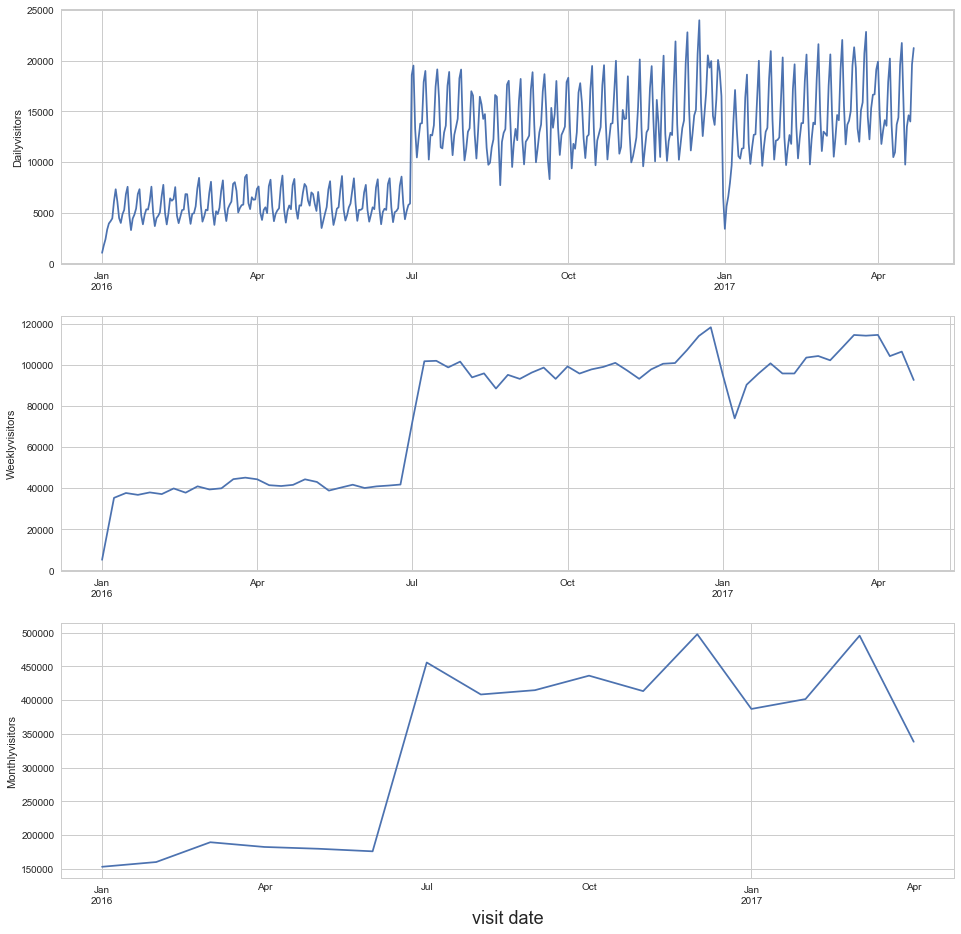

In [6]:
fig,ax = plt.subplots(3,1, figsize = (16,16))
Fre = ["Daily", "Weekly", "Monthly"]

for i,fre in enumerate(["D","W","M"]):
    air_visit_data.groupby('visit_date')['visitors'].sum().resample(fre).sum().plot(ax = ax[i])
    ax[i].set(ylabel = (Fre[i] + ' visitors'), xlabel = "")
plt.xlabel('visit date', fontsize = 18)

<a id = '2.3'></a>
### 2.3 Reservations

In [7]:
# air and hpg sometimes have the same store information but record them using different ID number
# convert hpg_store_id to air_store_id
hpg_reserve = hpg_reserve.merge(store_id_relation, on = 'hpg_store_id', how = 'left')
air = hpg_reserve['air_store_id']
hpg_reserve['hpg_store_id'] = air
hpg_reserve = hpg_reserve[hpg_reserve['hpg_store_id'].notnull()]
hpg_reserve = hpg_reserve.drop('air_store_id', axis = 1)
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
103,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4
121,air_08cb3c4ee6cd6a22,2016-01-01 19:00:00,2016-01-01 16:00:00,2
272,air_6b15edd1b4fbb96a,2016-01-02 17:00:00,2016-01-01 22:00:00,3
348,air_37189c92b6c761ec,2016-01-02 18:00:00,2016-01-02 17:00:00,2
349,air_37189c92b6c761ec,2016-01-02 18:00:00,2016-01-01 20:00:00,2


In [8]:
# We think that actual visit will depend on the time difference between reservation and the expected visit date
# therefore we will add new features to capture the relationship

def delta_reservation(df):
    # Calculating the difference between reservation time and visit time
    df['delta_reservation'] = df['visit_datetime'] - df['reserve_datetime']
    # creating a variable for reservations made within 2 days of visit
    df['delta_2days'] = df['delta_reservation'].apply(lambda x: int(x.days < 2))
    # creating a variable for reservations made within 7 days of visit
    df['delta_7days'] = df['delta_reservation'].apply(lambda x: int(2 <= x.days < 7))
    # creating a variable for reservations made over 1 week in advance
    df['delta_long'] = df['delta_reservation'].apply(lambda x: int(x.days >= 7))
    return df

# Combine rervations from air and hpg
air_reserve = delta_reservation(air_reserve)
hpg_reserve = delta_reservation(hpg_reserve)

air_reserve.rename(columns = {'air_store_id':'store_id'}, inplace = True)
hpg_reserve.rename(columns = {'hpg_store_id':'store_id'}, inplace = True)
total_reserve = pd.concat([air_reserve, hpg_reserve])
total_reserve['date'] = total_reserve['visit_datetime'].apply(lambda x:x.date())
total_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,delta_reservation,delta_2days,delta_7days,delta_long,date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,03:00:00,1,0,0,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,00:00:00,1,0,0,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,00:00:00,1,0,0,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,04:00:00,1,0,0,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19:00:00,1,0,0,2016-01-01


- __How many unique stores are reserved?__
- __How many unique stores are visited?__

In [9]:
num_reserve = total_reserve['store_id'].nunique()
num_visit = air_visit_data['air_store_id'].nunique()
print("{} stores are reserved".format(num_reserve))
print("{} stores are visited".format(num_visit))

333 stores are reserved
829 stores are visited


#### FIGURE 3: Total Number of Reservations VS Total Number of Visitors

__Observations: __

- In general, reservations are only a small portion of total visits.
- There is a huge jump in reservation numbers in November 2016. 
- Reservation trend does not seem to reflect visitor trend well.

Text(0,0.5,'Visitors')

Text(0.5,0,'Date')

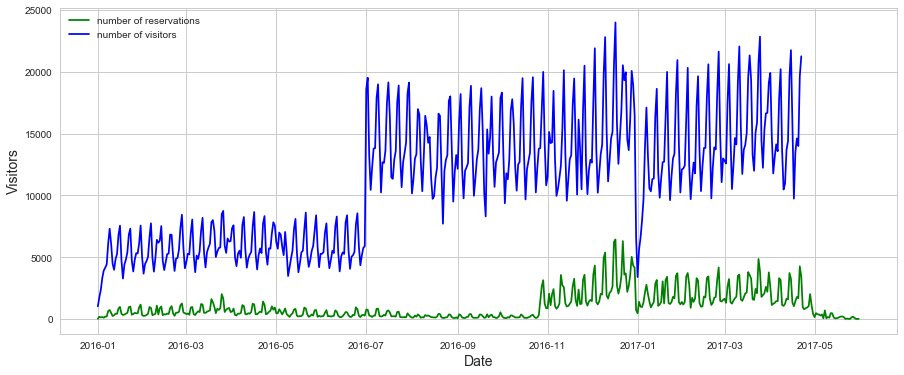

In [10]:
reserve_by_date = total_reserve.groupby('date').sum().reset_index()
visit_by_date = air_visit_data.groupby('visit_date').sum().reset_index()

plt.plot(reserve_by_date['date'], reserve_by_date['reserve_visitors'], color = 'green', label = 'number of reservations')
plt.plot(visit_by_date['visit_date'], visit_by_date['visitors'], color = 'blue', label = 'number of visitors')
plt.legend(loc = 'upper left')
plt.ylabel('Visitors', fontsize = 14)
plt.xlabel('Date', fontsize = 14)

- __Is the increse at 2016-07 cause by an increase in the number of stores?__
- __Yes__

In [11]:
air_visit_data_05 = air_visit_data[(air_visit_data['visit_date'].apply(lambda x: x.year) == 2016) & (air_visit_data['visit_date'].apply(lambda x: x.month) < 6)]
air_visit_data_07 = air_visit_data[(air_visit_data['visit_date'].apply(lambda x: x.year) == 2016) & (air_visit_data['visit_date'].apply(lambda x: x.month) > 7)]
air_visit_data_05['air_store_id'].nunique()
air_visit_data_07['air_store_id'].nunique()

316

818

#### FIGURE 4: Visit Time VS Reservation Time

__Observations:__
- Most activities happen in the afternoon and evening.
- Compared to dinner, very few people have lunch outside.

([<matplotlib.axis.XTick at 0x1a0649943c8>,
 <a list of 6 Text xticklabel objects>)

Text(0,0.5,'reserve visitors')

Text(0.5,0,'time')

(0, 86400)

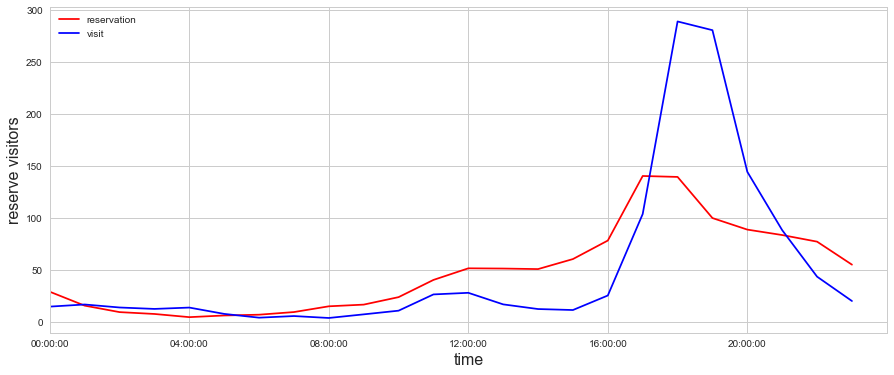

In [12]:
df1 = total_reserve.groupby('reserve_datetime')['reserve_visitors'].sum()
reserve_time = df1.groupby(df1.index.time).mean().reset_index()

df2 = total_reserve.groupby('visit_datetime')['reserve_visitors'].sum()
visit_time = df2.groupby(df2.index.time).mean().reset_index()

hourly_ticks = 4 * 60 * 60 * np.arange(6) #4 hours per interval, 60 min per hour, 60 second per min, 6(24/4)
plt.plot(reserve_time['index'], reserve_time['reserve_visitors'],color = 'red', label = 'reservation')
plt.plot(visit_time['index'], visit_time['reserve_visitors'], color = 'blue', label = 'visit')
plt.xticks(hourly_ticks)
plt.legend(loc = 'upper left')
plt.ylabel('reserve visitors', fontsize = 16)
plt.xlabel('time', fontsize = 16)
plt.xlim(0,4 * 60 * 60 * 6)

#### FIGURE 5: Visit Weekday VS Reservation Weekday

__Observations: __
- There are more reservations made on weekdays than weekends while Friday and Saturday are the most popular days for visits.
- Sunday and Monday have the fewest activities.

Text(0,0.5,'reserve visitors')

Text(0.5,0,'day of week')

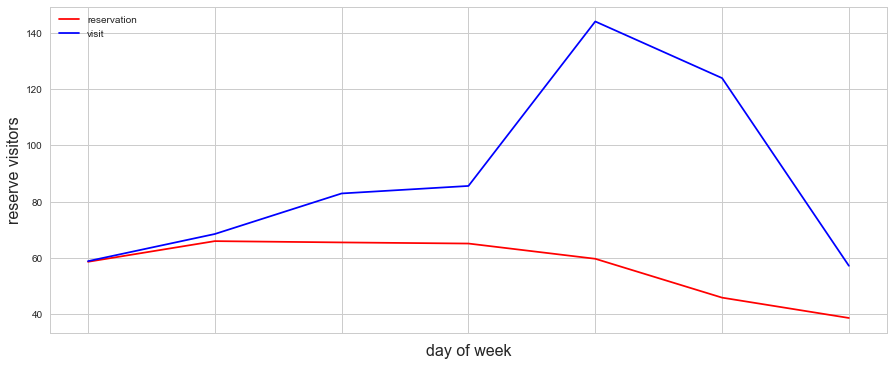

In [13]:
by_weekday_df1 = df1.groupby(df1.index.dayofweek).mean()
by_weekday_df1.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday_df1.plot(color = 'red', label = 'reservation')

by_weekday_df2 = df2.groupby(df2.index.dayofweek).mean()
by_weekday_df2.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday_df2.plot(color = 'blue', label = 'visit')
plt.legend(loc = 'upper left')
plt.ylabel('reserve visitors', fontsize = 16)
plt.xlabel('day of week', fontsize = 16)

#### FIGURE 6: Reservation time on weekday and weekend

__Observations:__
- There is no obvious difference between reservation time on weekday and weekedend.

(0, 86400)

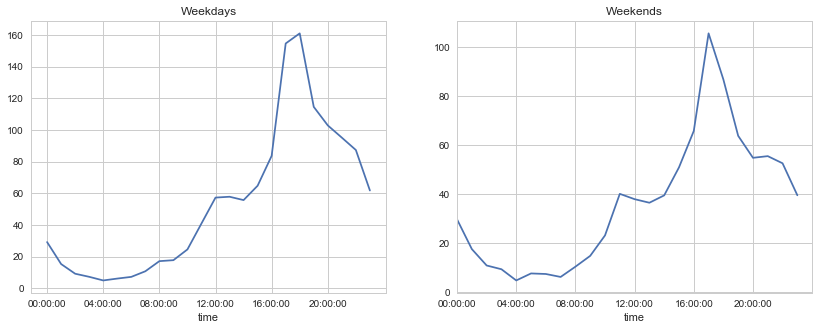

In [14]:
weekend = np.where(df1.index.weekday < 5, 'Weekday', 'Weekend')
by_time = df1.groupby([weekend, df1.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks)
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks);
plt.xlim(0,4 * 60 * 60 * 6)

#### FIGURE 7: Average Number of Visitors per Store for Holidays and non-Holidays.

__Observations:__
- There are more visitos on holidays. We need to do a statistical test to see if the difference is significant.

In [ ]:
date_info = date_info.rename(columns = {'calendar_date':'visit_date'})
air_holiday = air_visit_data.merge(date_info, how = 'inner', on = 'visit_date')
holiday = air_holiday.groupby('holiday_flg')['visitors'].mean()
holiday.index = ['not holiday', 'holiday']
holiday.plot(kind = 'bar')
plt.xticks(rotation = 'horizontal', fontsize = 16)
plt.ylabel('visitors', fontsize =16)

In [16]:
date_info = date_info.rename(columns = {'calendar_date':'visit_date'})
air_holiday = air_visit_data.merge(date_info, how = 'inner', on = 'visit_date')
holiday = air_holiday.groupby('holiday_flg')['visitors'].mean()
holiday.index = ['not holiday', 'holiday']
holiday

# Hypothesis testing
holiday_0 = air_holiday[air_holiday['holiday_flg'] == 0]['visitors']
holiday_1 = air_holiday[air_holiday['holiday_flg'] == 1]['visitors']
stats.ttest_ind(holiday_0, holiday_1)

not holiday    20.828064
holiday        23.703327
Name: visitors, dtype: float64

Ttest_indResult(statistic=-18.90934338944833, pvalue=1.0851683125688138e-79)

Seems holiday has even a positive influence.

<a id = '2.4'></a>
### 2.4 Area

In [17]:
store_info = air_visit_data.copy()
store_info = store_info.merge(air_store_info,on = "air_store_id", how = 'inner')
store_info['air_store_id'].nunique()
store_info.head()

829

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [18]:
store_info["area1"],store_info["area2"],store_info["area3"] = store_info["air_area_name"].str.split(' ', 2).str
store_info.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,area1,area2,area3
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen


#### FIGURE 8: Average Number of Visitors by Area

__Observations: __
- Shizuoka-ken has the highest average number of visitors while Fukuoka-ken has the lowest.

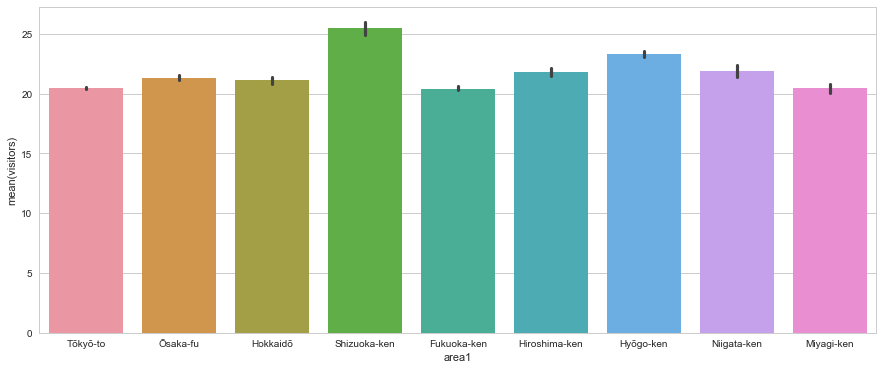

In [19]:
#area1 = store_info.groupby("area1")["visitors"].mean().reset_index()
#area1.head(3)
sns.barplot(x = store_info["area1"], y=store_info["visitors"])

<a id = '2.5'></a>
### 2.5 Genre

#### FIGURE 9: Average Number of Visitors by Genre

__Observations:__
- Asian Restaurants are the most popular.
- Bar/Cocktail is the least popular.

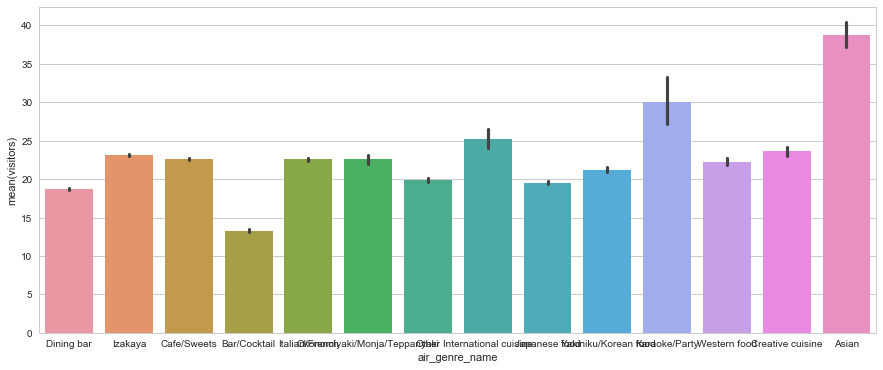

In [20]:
sns.barplot(x = store_info["air_genre_name"], y=store_info["visitors"])

In [21]:
genre_area = store_info.groupby(["area1","air_genre_name"])["visitors"].aggregate([max,np.median,np.mean]).reset_index()
genre_area.rename(columns={'max': 'area1_genre_max', 'median': 'area1_genre_median','mean': 'area1_genre_mean'},inplace=True)
genre_area.head(3)

,area1,air_genre_name,area1_genre_max,area1_genre_median,area1_genre_mean
0,Fukuoka-ken,Bar/Cocktail,118,9.0,12.001578
1,Fukuoka-ken,Cafe/Sweets,627,16.0,21.050838
2,Fukuoka-ken,Creative cuisine,88,16.0,20.742284


<a id = '3'></a>
## Step 3: Data Preparation for Modeling

### 3.1 Initialize train and text, merge with visit date (weekday and holiday)

In [22]:
train = air_visit_data.copy()
date_info = date_info.rename(columns = {'calendar_date':'visit_date'})
train = train.merge(date_info, how = 'left', on = 'visit_date')
#train = train.join(pd.get_dummies(train["day_of_week"],drop_first=True))
train["day_of_week"] = train["visit_date"].dt.weekday  #0 is monday, 6 is Sunday
train["fri_or_sat"] = train["day_of_week"].apply(lambda x: 1 if (x == 4 or x ==5) else 0)
train["month"] = train["visit_date"].dt.month
train.head()

test = sample_submission.copy()
test["air_store_id"] = test["id"].apply(lambda x: x[0:20])
test["visit_date"] = test["id"].apply(lambda x: x[21:])
test["visit_date"] = pd.to_datetime(test["visit_date"]) 
test = test.merge(date_info, how = 'left', on = 'visit_date')
#test = test.join(pd.get_dummies(train["day_of_week"],drop_first=True))
test["day_of_week"] = test["visit_date"].dt.weekday  #0 is monday, 6 is Sunday
test["fri_or_sat"] = test["day_of_week"].apply(lambda x: 1 if (x == 4 or x ==5) else 0)
test["month"] = test["visit_date"].dt.month
test.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,fri_or_sat,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,0,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,0,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,0,1,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,0,0,1


,id,visitors,air_store_id,visit_date,day_of_week,holiday_flg,fri_or_sat,month
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,6,0,0,4
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,0,0,0,4
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,1,0,0,4
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,2,0,0,4
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,3,0,0,4


### 3.2 Merge with store information (gerne and area)

In [23]:
train = train.merge(air_store_info,on = "air_store_id", how = 'inner')
train["area1"],train["area2"],train["area3"] = train["air_area_name"].str.split(' ', 2).str
train = train.merge(genre_area,on = ["air_genre_name","area1"],how = "left")
#train = train.join(pd.get_dummies(train["air_genre_name"],drop_first=True))
#train = train.join(pd.get_dummies(train["area2"],drop_first=True))
#train = train.drop(['air_genre_name','air_area_name','area2','latitude','longitude'], axis = 1)
train.head(3)

test = test.merge(air_store_info,on = "air_store_id", how = 'inner')
test["area1"],test["area2"],test["area3"] = test["air_area_name"].str.split(' ', 2).str
test = test.merge(genre_area,on = ["air_genre_name","area1"],how = "left")
#test = test.join(pd.get_dummies(test["air_genre_name"],drop_first=True))
#test = test.join(pd.get_dummies(test["area2"],drop_first=True))
#test = test.drop(['air_genre_name','air_area_name','latitude','longitude'], axis = 1)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,fri_or_sat,month,air_genre_name,air_area_name,latitude,longitude,area1,area2,area3,area1_genre_max,area1_genre_median,area1_genre_mean
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen,348,14.0,17.928582
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen,348,14.0,17.928582
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen,348,14.0,17.928582


In [24]:
for f in train.iloc[:,1:].columns: 
    if train[f].dtype=='object':
        print(f)
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values.astype('str')) + list(test[f].values.astype('str')))
        train[f] = lbl.transform(list(train[f].values.astype('str')))
        test[f] = lbl.transform(list(test[f].values.astype('str')))

air_genre_name


LabelEncoder()

air_area_name


LabelEncoder()

area1


LabelEncoder()

area2


LabelEncoder()

area3


LabelEncoder()

### 3.3 Merge with min/max/mean/median visit by store

In [25]:
visit_by_store = train.groupby(["air_store_id"])["visitors"].aggregate([min,max,np.median,np.mean]).reset_index()
train = train.merge(visit_by_store,how = "left", on = "air_store_id")
test = test.merge(visit_by_store,how = "left", on = "air_store_id")
train.head(3)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,fri_or_sat,month,air_genre_name,air_area_name,latitude,...,area1,area2,area3,area1_genre_max,area1_genre_median,area1_genre_mean,min,max,median,mean
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,0,1,4,62,35.658068,...,7,29,77,348,14.0,17.928582,1,61,22.0,22.782609
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,0,1,4,62,35.658068,...,7,29,77,348,14.0,17.928582,1,61,22.0,22.782609
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,1,4,62,35.658068,...,7,29,77,348,14.0,17.928582,1,61,22.0,22.782609


### 3.4 Merge with min/max/mean/median visit by store on same weekday

In [26]:
visit_by_store_weekly = train.groupby(["air_store_id","day_of_week"])["visitors"].aggregate([min,max,np.median,np.mean]).reset_index()
train = train.merge(visit_by_store_weekly,how = "left", on = ["air_store_id","day_of_week"], suffixes=["_all", "_weekday"])
test = test.merge(visit_by_store_weekly,how = "left", on = ["air_store_id","day_of_week"], suffixes=["_all", "_weekday"])
train.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,fri_or_sat,month,air_genre_name,air_area_name,latitude,...,area1_genre_median,area1_genre_mean,min_all,max_all,median_all,mean_all,min_weekday,max_weekday,median_weekday,mean_weekday
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,0,1,4,62,35.658068,...,14.0,17.928582,1,61,22.0,22.782609,7,57,25.0,23.843750
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,0,1,4,62,35.658068,...,14.0,17.928582,1,61,22.0,22.782609,2,54,21.0,20.292308
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,1,4,62,35.658068,...,14.0,17.928582,1,61,22.0,22.782609,4,61,35.0,34.738462
3,air_ba937bf13d40fb24,2016-01-16,22,5,0,1,1,4,62,35.658068,...,14.0,17.928582,1,61,22.0,22.782609,6,53,27.0,27.651515
4,air_ba937bf13d40fb24,2016-01-18,6,0,0,0,1,4,62,35.658068,...,14.0,17.928582,1,61,22.0,22.782609,2,34,12.0,13.754386


### 3.5 Merge with reserve by date

In [27]:
reserve_by_date = total_reserve.groupby(["store_id","date"]).sum().reset_index()
reserve_by_date = reserve_by_date.rename(columns = {'store_id':'air_store_id','date':'visit_date'})
reserve_by_date["visit_date"] = pd.to_datetime(reserve_by_date["visit_date"])

train = train.merge(reserve_by_date, how = "left", on=["air_store_id","visit_date"])
test = test.merge(reserve_by_date, how = "left", on=["air_store_id","visit_date"])
train.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,fri_or_sat,month,air_genre_name,air_area_name,latitude,...,median_all,mean_all,min_weekday,max_weekday,median_weekday,mean_weekday,reserve_visitors,delta_2days,delta_7days,delta_long
0,air_ba937bf13d40fb24,2016-01-13,25,2,0,0,1,4,62,35.658068,...,22.0,22.782609,7,57,25.0,23.843750,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,3,0,0,1,4,62,35.658068,...,22.0,22.782609,2,54,21.0,20.292308,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,4,0,1,1,4,62,35.658068,...,22.0,22.782609,4,61,35.0,34.738462,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,5,0,1,1,4,62,35.658068,...,22.0,22.782609,6,53,27.0,27.651515,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,0,0,0,1,4,62,35.658068,...,22.0,22.782609,2,34,12.0,13.754386,NaN,NaN,NaN,NaN


### 3.6 Final Touch

In [28]:
print("There are {} unique restaurants in train data set, while just {} of them have reservation.".format(
    train["air_store_id"].nunique(),reserve_by_date["air_store_id"].nunique()))

There are 829 unique restaurants in train data set, while just 333 of them have reservation.


__For restaurants that can have reservation, fill na with 0 (means, no reservation on that day)__

In [29]:
train.loc[train["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
train[train["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(0)

test.loc[test["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
test[test["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(0)

__For testaurants that never have reservation, fill na with -1__

In [30]:
train.loc[~train["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
train[~train["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(-1)

test.loc[~test["air_store_id"].isin(reserve_by_date["air_store_id"].unique()),"reserve_visitors"] = \
test[~test["air_store_id"].isin(reserve_by_date["air_store_id"].unique())]["reserve_visitors"].fillna(-1)

<a id = '4'></a>
## Step 4: Modeling

<a id = '4.1'></a>
### 4.1 Loading Package & Split Test & Train

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [32]:
Xtrain = train.drop(["visitors","air_store_id","visit_date","delta_7days","day_of_week","air_area_name"],axis=1)
Xtrain = Xtrain.fillna(-1)
Ytrain = train["visitors"]

Xtest = test.drop(["id","visitors","air_store_id","visit_date","delta_7days","day_of_week","air_area_name"],axis=1)
Xtest = Xtest.fillna(-1)

In [33]:
train_x, test_x, train_y, test_y = \
train_test_split(Xtrain, Ytrain, random_state=1026, test_size=0.2)

#### Save text and train

In [81]:
test_x.to_csv("../input/test_x.csv",index = False)
test_y.to_csv("../input/test_y.csv",index = False)
Xtest_book = test.drop(["visitors","air_store_id","visit_date","delta_7days","day_of_week","air_area_name"],axis=1)
Xtest_book.to_csv("../input/Xtest_book.csv",index = False)

In [35]:
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(X = train_x, y = train_y, f="../input/train.libsvm")
dump_svmlight_file(X = test_x, y = test_y, f="../input/test.libsvm")

<a id = '4.2'></a>
### 4.2 Define RMSLE

In [34]:
def rmsle(y, yp): 
    """
    Compute the Root Mean Squared Log Error for hypthesis yp and targets y
    Args:
        yp - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log1p(yp) - np.log1p(y)).mean())

acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)

<a id = '4.3'></a>
### 4.3 Set up Cross Validation

In [35]:
from sklearn.cross_validation import KFold
def cv_rmsle (k,model,Xtrain,Ytrain,**kwargs):
    error = []
    n = Xtrain.shape[0]
    kf = KFold(n, n_folds = k, shuffle=True)
    #loop through K fold
    for i, (train_index, test_index) in enumerate(kf):#get the train and test index generated by Kfold
        x_tr = Xtrain.iloc[train_index] #xtrain for a fold
        y_tr = Ytrain.iloc[train_index] #ytrain for a fold
        x_te = Xtrain.iloc[test_index]  #xtest for a fold
        y_te = Ytrain.iloc[test_index]  #ytest for a fold
        
        #predict and calculate rmsle
        __, pred_yte = globals()[model](x_tr,y_tr,x_te,**kwargs)
        error.append(rmsle(y_te,pred_yte))
        print("finish {} round of {}, rmlse = {}".format(i,model,rmsle(y_te,pred_yte)))
    return error

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a id = '4.4'></a>
### 4.4 Linear Rregression

In [68]:
import statsmodels.api as sm

In [66]:
def linear_reg(train_x,train_y,test_x): 
    x = sm.add_constant(train_x, has_constant='add')
    est = sm.OLS(train_y, x)
    est = est.fit()
    lm_summary = est.summary()
    pred_x = sm.add_constant(test_x, has_constant='add')
    pred_y= est.predict(pred_x)
    return (lm_summary,pred_y)

In [84]:
lm_summary,pred_testy = linear_reg(train_x,train_y,test_x)
rmsle(test_y,pred_testy)

0.5333079898688802

In [85]:
lm_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               visitors   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                 1.168e+04
Date:                Mon, 05 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:28:52   Log-Likelihood:            -7.7015e+05
No. Observations:              201686   AIC:                         1.540e+06
Df Residuals:                  201662   BIC:                         1.541e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2705      2.118      0.128      0.898      -3.881       4.422
holiday_flg            3.4601      0.112     30.903      0.000       3.241       3.680
fri_or_sat            -0.0864      0.058     -1.500      0.134      -0.199       0.027
month                  0.0320      0.007      4.782      0.000       0.019       0.045
air_genre_name        -0.0501      0.009     -5.472      0.000      -0.068      -0.032
latitude              -0.0638      0.028     -2.311      0.021      -0.118      -0.010
longitude              0.0059      0.022      0.268      0.789      -0.037       0.049
area1                  0.0564      0.023      2.435      0.015       0.011       0.102
area2                  0.0005      0.002      0.254      0.800      -0.003       0.004
area3                 -0.0007      0.001     -0.763      0.445      -0.002       0.001
area1_genre_max        0.0001      0.000      0.877      0.380      -0.000       0.000
area1_genre_median     0.0319      0.021      1.537      0.124      -0.009       0.073
area1_genre_mean      -0.0466      0.021     -2.208      0.027      -0.088      -0.005
min_all                0.0315      0.013      2.424      0.015       0.006       0.057
max_all                0.0014      0.000      3.128      0.002       0.001       0.002
median_all             0.0670      0.016      4.185      0.000       0.036       0.098
mean_all              -0.0626      0.017     -3.697      0.000      -0.096      -0.029
min_weekday            0.0167      0.007      2.519      0.012       0.004       0.030
max_weekday            0.0041      0.001      3.770      0.000       0.002       0.006
median_weekday        -0.0006      0.017     -0.035      0.972      -0.034       0.033
mean_weekday           0.9591      0.019     49.551      0.000       0.921       0.997
reserve_visitors       0.3785      0.006     61.453      0.000       0.366       0.391
delta_2days           -0.1079      0.029     -3.680      0.000      -0.165      -0.050
delta_long            -1.4450      0.040    -35.979      0.000      -1.524      -1.366
==============================================================================
Omnibus:                   297802.405   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1444659160.250
Skew:                           8.078   Prob(JB):                         0.00
Kurtosis:                     417.305   Cond. No.                     3.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
k = 5
model = "linear_reg"
rmsle_ols = cv_rmsle(k, model, Xtrain,Ytrain)
rmsle_ols = np.mean(rmsle_ols)
rmsle_ols

finish 0 round of linear_reg, rmlse = 0.5337994459742469
finish 1 round of linear_reg, rmlse = 0.5322499517236181
finish 2 round of linear_reg, rmlse = 0.5314546875619566
finish 3 round of linear_reg, rmlse = 0.5354579542122219
finish 4 round of linear_reg, rmlse = 0.533287112191213


0.5332498303326514

#### linear regression final result

In [54]:
lm_summary,pred_y = linear_reg(Xtrain,Ytrain,Xtest)
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.448989
1,air_00a91d42b08b08d9_2017-04-24,22.165827
2,air_00a91d42b08b08d9_2017-04-25,23.981833
3,air_00a91d42b08b08d9_2017-04-26,27.899902
4,air_00a91d42b08b08d9_2017-04-27,29.575418


In [143]:
sample_submission.to_csv("../output/lm1.csv",index=False)

<a id = '4.5'></a>
### 4.5 Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
def random_forest(train_x,train_y,test_x,**kwargs):
    forest = RandomForestRegressor(**kwargs)
    forest.fit(train_x, train_y)
    pred_y = forest.predict(test_x)
    return forest,pred_y

def plot_rf_importance(forest):
    imp = pd.DataFrame(forest.feature_importances_, columns = [ 'Importance' ], index = train_x.columns)
    
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 15].plot( kind = 'barh' )

#### grid search to find optimal parameters for random forest

In [58]:
acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)
model = RandomForestRegressor()
parameters = {'n_estimators': [100], 
              'max_features': ['log2', 'sqrt','auto'], #The number of features to consider when looking for the best split
              'max_depth': [5, 10,12], 
              'min_samples_split': [2, 3, 5],
             }
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x, train_y)
model_params = grid_obj.best_params_
model_params
#grid_obj.best_score_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

#### FIGURE 11: Top Features pick by Random Forest Algorithm

__Interpretations:__
- min_weekday means 
- median_all means
- delta_long means

# !!!! SOMEONE ADD SOME INTERPRETATION OF THE VARIABLES HERE. IT 'S NOT VERY OBVIOUS WHAT THESE VARIABLES MEAN

0.5257264891187505

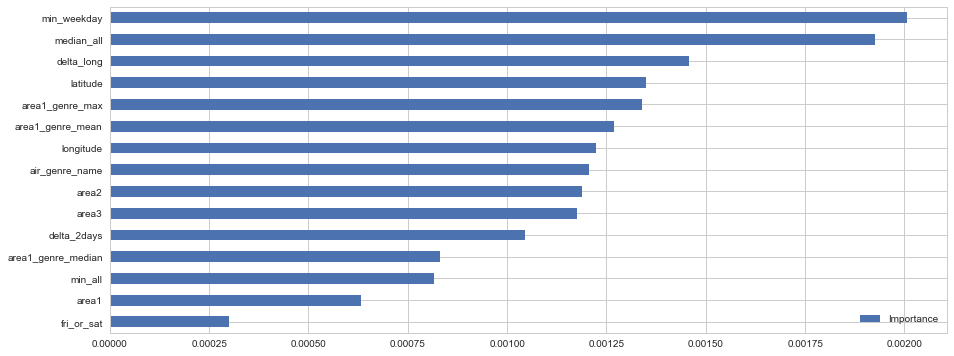

In [45]:
model_params = {'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}
forest, pred_testy = random_forest(train_x,train_y,test_x,**model_params)
rmsle(test_y,pred_testy)
plot_rf_importance(forest)

In [58]:
k = 5
model = "random_forest"
model_params = {'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 60}
rmsle_rf = cv_rmsle(k, model, Xtrain,Ytrain,**model_params)
rmsle_rf = np.mean(rmsle_rf)
rmsle_rf

finish 0 round of random_forest, rmlse = 0.5255914468507514
finish 1 round of random_forest, rmlse = 0.5255024307516576
finish 2 round of random_forest, rmlse = 0.5241612343155102
finish 3 round of random_forest, rmlse = 0.5226477454740996
finish 4 round of random_forest, rmlse = 0.5309899640537721


0.5257785642891581

#### Random forest final result

In [65]:
forest, pred_y = random_forest(Xtrain,Ytrain,Xtest,**model_params)
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.948231
1,air_00a91d42b08b08d9_2017-04-24,20.833786
2,air_00a91d42b08b08d9_2017-04-25,24.019948
3,air_00a91d42b08b08d9_2017-04-26,27.449413
4,air_00a91d42b08b08d9_2017-04-27,29.702137


In [37]:
sample_submission.to_csv("../output/rf2.csv",index=False)

<a id = '4.6'></a>
### 4.6 XGBoost

In [36]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [37]:
def opt_num_boost_round(train_x,train_y,xgb_params):
    dtrain = xgb.DMatrix(train_x, train_y)
    cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=150, early_stopping_rounds=100,
        verbose_eval=20, show_stdv=False)
    cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
    
def xgb_model(train_x,train_y,test_x,xgb_params,num_round):
    dtrain = xgb.DMatrix(train_x, train_y)
    xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_round)
    pred = xgb_model.predict(xgb.DMatrix(test_x))
    return xgb_model,pred

In [38]:
acc_scorer = make_scorer(score_func = rmsle, greater_is_better = False)
model = XGBClassifier(nthread=3, scale_pos_weight=1, seed=27)
model_params = {'learning_rate': [0.05],
              'n_estimators': [150], 
              'max_depth': [8, 10, 12], 
              'subsample': [0.7,0.8],
              'colsample_bytree': [0.7],
              'objective': ['reg:linear'],
              'min_child_weight': [1],
              'gamma': [0]
             }
grid_obj = GridSearchCV(model, model_params, scoring=acc_scorer)
grid_obj = grid_obj.fit(test_x, test_y)
model_params = grid_obj.best_params_
model_params
#grid_obj.best_score_

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 150,
 'objective': 'reg:linear',
 'subsample': 0.7}

#### FIGURE 12: RMSE of Training Set VS MSE of Testing Set

__Interpretations:__
- In the graph below, y axis is the RMSE, x aixs is ???
- This visualization is useful to choose the best ???

# !!!!!! SOMEONE FINISH THE INTERPRETATION OF THE GRAPH
# ALSO, ARE RMSE AND RMSLE DIFFERENT THINGS? WHAT'S THE DIFFERENCE?

[0]	train-rmse:25.4007	test-rmse:25.4085
[20]	train-rmse:13.5199	test-rmse:13.7497
[40]	train-rmse:10.8733	test-rmse:11.332
[60]	train-rmse:10.3339	test-rmse:10.9617
[80]	train-rmse:10.1817	test-rmse:10.9054
[100]	train-rmse:10.0872	test-rmse:10.8983
[120]	train-rmse:10.0202	test-rmse:10.9011
[140]	train-rmse:9.95711	test-rmse:10.8975


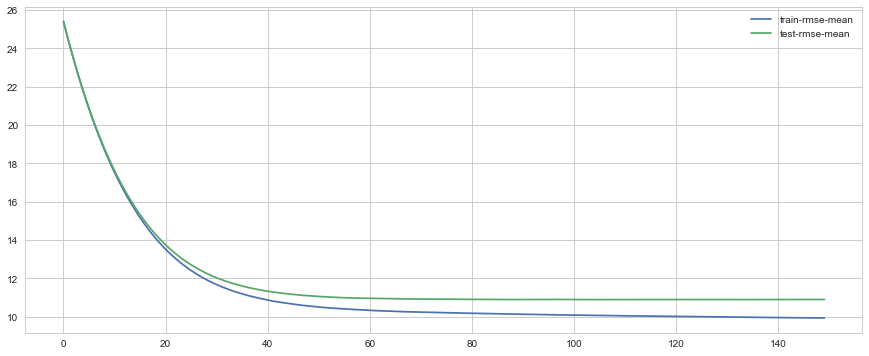

In [73]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
opt_num_boost_round(train_x,train_y,xgb_params)

In [74]:
xgboost_model, pred_testy = xgb_model(train_x,train_y,test_x,xgb_params,70)
rmsle(test_y,pred_testy)

0.5182742361749587

In [62]:
k = 5
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
model = "xgb_model"
model_params = {
   "xgb_params": xgb_params,
    "num_round": 70
}

rmsle_xgb = cv_rmsle(k, model, Xtrain,Ytrain,**model_params)
rmsle_xgb = np.mean(rmsle_xgb)
rmsle_xgb

finish 0 round of xgb_model, rmlse = 0.5162937433224921
finish 1 round of xgb_model, rmlse = 0.5227695325892232
finish 2 round of xgb_model, rmlse = 0.5188040666327323
finish 3 round of xgb_model, rmlse = 0.5201080802747058
finish 4 round of xgb_model, rmlse = 0.5156263027321398


0.5187203451102587

#### XGBoost final result

In [103]:
xgboost_model,pred_y = xgb_model(Xtrain,Ytrain,Xtest,xgb_params,60)
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.230275
1,air_00a91d42b08b08d9_2017-04-24,19.570179
2,air_00a91d42b08b08d9_2017-04-25,22.631840
3,air_00a91d42b08b08d9_2017-04-26,26.775152
4,air_00a91d42b08b08d9_2017-04-27,28.565804


In [187]:
sample_submission.to_csv("../output/xgb2.csv",index=False)

<a id = '4.7'></a>
### 4.7 Model Comparison

In [80]:
cv_compare = {"ols": rmsle_ols,
            "random forest": rmsle_rf,
            "xgboost": rmsle_xgb

}          
cv_compare = pd.DataFrame.from_dict(cv_compare,orient='index')
cv_compare.columns = ["rmsle"]
cv_compare

,rmsle
ols,0.533250
random forest,0.525779
xgboost,0.518720


#### Save Model

In [104]:
xgboost_model.save_model('../model/xgb02.model')

In [2]:
xgb_load = xgb.Booster({'nthread':4}) #init model
xgb_load.load_model("../model/xgb02.model") # load model

In [107]:
t = xgb_load.predict(xgb.DMatrix(Xtest))
t[0:10]

array([ 2.2302752, 19.570179 , 22.63184  , 26.775152 , 28.565804 ,
       35.27316  , 21.732435 ,  2.2302752, 19.63949  , 22.70115  ],
      dtype=float32)

<a id = '5'></a>
## Step 5: Summary

The model we developed has a predictive power of ????%
Any Interesting Takeaways for this exercise/Highlights?
Anything to improve?

# !!! SOMEONE GIVE SOME IDEAS FOR THE CELL ABOVE. I CAN HELP PUT THEM INTO PARAGRAPHS